<a href="https://colab.research.google.com/github/kushal-ks/PNM-ML-POC/blob/master/pnm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib import dates
from itertools import chain
import zipfile
import csv
import os
import math

print(tf.__version__)

2.2.0-rc2


In [0]:
local_zip = './pnm_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/')
zip_ref.close()

In [14]:
path = "./data/"
parent_dir_list = os.listdir(path) 
current_date_time = datetime.now()
modem_data = {}
min_date_time = ''
max_date_time = ''
min_mr_lavel = ''
max_mr_lavel = ''
record_id = 0

print(type(min_date_time))
print(parent_dir_list)
for pl_num, pl in enumerate(parent_dir_list):
    modem_list_path = path+"/"+pl
    modem_list_dir = os.listdir(modem_list_path) 
    
    for ml_num, ml in enumerate(modem_list_dir):
      detail_file_path = modem_list_path+"/"+ml
      detail_file_list = os.listdir(detail_file_path)
      record_id = 0
      modem_detail_list = []

      for key in detail_file_list:
          with open(detail_file_path+"/"+str(key)) as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)

            for row in reader:
              record_id += 1
              poll_date = datetime.strptime(str(row[3]), '%Y-%m-%d %H:%M:%S.%f')

              if (pl_num == 0 and ml_num == 0 or poll_date > max_date_time) :
                max_date_time = poll_date
              
              if (pl_num == 0 and ml_num == 0 or poll_date < min_date_time):
                min_date_time = poll_date

              if (pl_num == 0 and ml_num == 0 or float(row[39]) > max_mr_lavel):
                max_mr_lavel = math.ceil(float(row[39]))
              
              if (pl_num == 0 and ml_num == 0 or float(row[39]) < min_mr_lavel):
                min_mr_lavel = math.ceil(float(row[39]))
              
              # day_diff = current_date_time - poll_date;
              modem_detail_list.append({"id": record_id, "mr_lavel": float(row[39]), "poll_time": row[3], "worst_severity": row[len(row) - 1]})
            modem_detail_list.sort(key = lambda x:x['poll_time']) 
            modem_data[ml] = modem_detail_list
day_difference = max_date_time - min_date_time
print(day_difference.days)
print(max_mr_lavel)
print(min_mr_lavel)
print(max_date_time)
print(min_date_time)
print(modem_data)
              

<class 'str'>
['cmts_1', 'cmts_2']
39
0
-37
2019-08-18 16:00:52.032000
2019-07-10 04:41:20.603000
{'002374f67ad9': [{'id': 21, 'mr_lavel': 0.0, 'poll_time': '2019-07-12 16:00:11.525', 'worst_severity': 'invalid'}, {'id': 20, 'mr_lavel': 0.0, 'poll_time': '2019-07-12 22:00:11.479', 'worst_severity': 'invalid'}, {'id': 19, 'mr_lavel': 0.0, 'poll_time': '2019-07-13 04:00:11.625', 'worst_severity': 'invalid'}, {'id': 18, 'mr_lavel': 0.0, 'poll_time': '2019-07-13 10:00:11.665', 'worst_severity': 'invalid'}, {'id': 17, 'mr_lavel': 0.0, 'poll_time': '2019-07-13 16:00:11.488', 'worst_severity': 'invalid'}, {'id': 16, 'mr_lavel': 0.0, 'poll_time': '2019-07-13 22:00:11.642', 'worst_severity': 'invalid'}, {'id': 15, 'mr_lavel': 0.0, 'poll_time': '2019-07-14 04:00:11.440', 'worst_severity': 'invalid'}, {'id': 14, 'mr_lavel': 0.0, 'poll_time': '2019-07-14 05:36:21.706', 'worst_severity': 'invalid'}, {'id': 13, 'mr_lavel': 0.0, 'poll_time': '2019-07-14 05:41:41.666', 'worst_severity': 'invalid'}, {'

In [0]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)

In [0]:
def configure_chart():
  plt.figure(figsize=(50, 10))
  plt.xlabel("Pool Time")
  plt.ylabel("MR Level")
  plt.xticks(rotation=90)


  # min_date_time_new = min_date_time.strftime('%Y-%m-%d')
  # max_date_time_new = max_date_time.strftime('%Y-%m-%d')
  # print("X level =====>>>>", min_date_time_new)
  # print("Y level =====>>>>", max_date_time_new)
  # plt.axis([min_date_time, max_date_time, min_mr_lavel, max_mr_lavel]) 
  plt.grid(True)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


# New Section

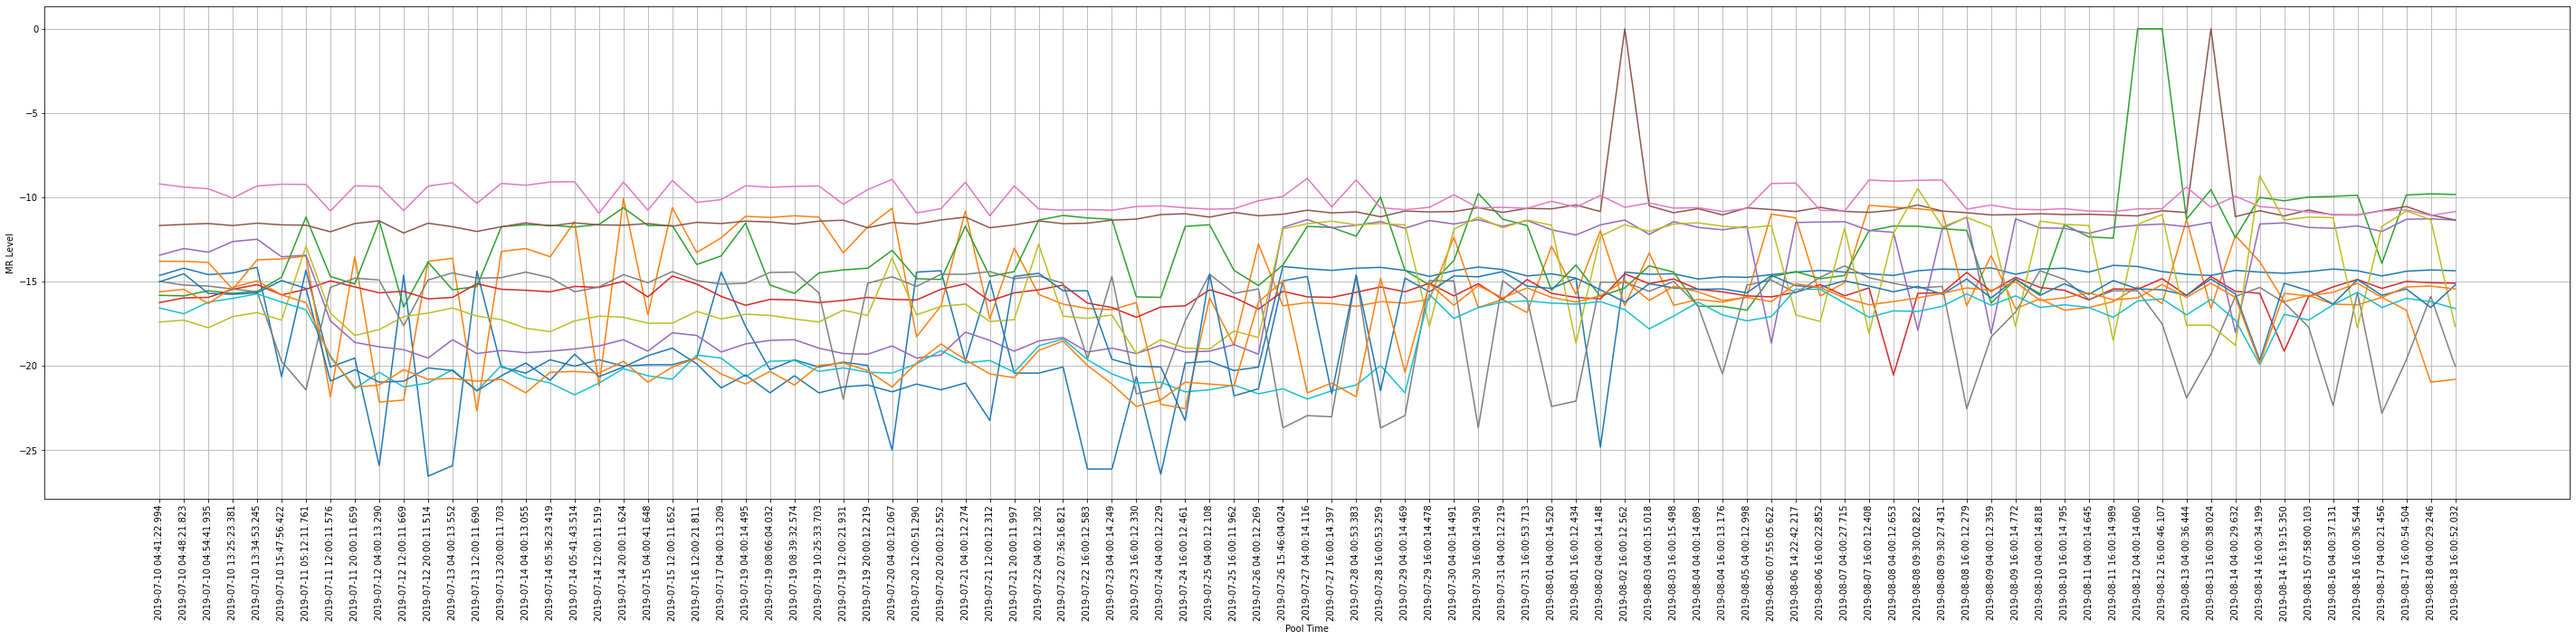

In [79]:
configure_chart()
counter = 0

red_zone_list = []
green_zone_list = []
yellow_zone_list = []

for key in modem_data.keys():
  counter = counter + 1 
  mr_levels = []
  poll_times = []
  data = modem_data[key]
  red_zone_counter = 0
  green_zone_counter = 0
  yellow_zone_counter = 0

  if len(data) == 95:
    for item in data:
      mr_levels.append(item["mr_lavel"])
      poll_times.append(item["poll_time"])

      if item["mr_lavel"] > -18:
        red_zone_counter += 1
      elif item["mr_lavel"] > -25 and item["mr_lavel"] <-18:
        yellow_zone_counter += 1
      elif item["mr_lavel"] < -25:
        green_zone_counter += 1
    if red_zone_counter > green_zone_counter and red_zone_counter > yellow_zone_counter:
      red_zone_list.append(mr_levels)
    elif green_zone_counter > yellow_zone_counter:
      green_zone_list.append(mr_levels)
    else:
      yellow_zone_list.append(mr_levels)
for x in red_zone_list:
    series = np.array(x)
    time = np.array(poll_times)
    plot_series(time, series)

In [0]:
time_train = poll_times
x_train = yellow_zone_list[:40]

for red_zone_item in red_zone_list[:6]:
  x_train.append(red_zone_item)

for green_zone_item in green_zone_list[:22]:
  x_train.append(green_zone_item)
  
x_valid = yellow_zone_list[40:]
for red_zone_item in red_zone_list[6:]:
  x_valid.append(red_zone_item)

for green_zone_item in green_zone_list[22:]:
  x_valid.append(green_zone_item)

In [0]:
window_size = 5
batch_size = 5
shuffle_buffer_size = 10

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [124]:
split_time = 70
series_new = red_zone_list[2]
x_train = series_new[:split_time]
x_valid = series_new[split_time:]
time_train = poll_times[:split_time]
time_valid = poll_times[split_time:]

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=500,verbose=1, matrics=["accuracy"])

Epoch 1/500
13/13 [==============================] - 0s 2ms/step - loss: 272.1859
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 258.0061
Epoch 3/500
13/13 [==============================] - 0s 2ms/step - loss: 240.4335
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 223.0959
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 206.8579
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 191.7447
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 177.8530
Epoch 8/500
13/13 [==============================] - 0s 2ms/step - loss: 165.0007
Epoch 9/500
13/13 [==============================] - 0s 2ms/step - loss: 152.9371
Epoch 10/500
13/13 [==============================] - 0s 2ms/step - loss: 141.9632
Epoch 11/500
13/13 [==============================] - 0s 2ms/step - loss: 131.6612
Epoch 12/500
13/13 [==============================] - 0s 2ms/step - loss: 122.1645
Epoch 13/500


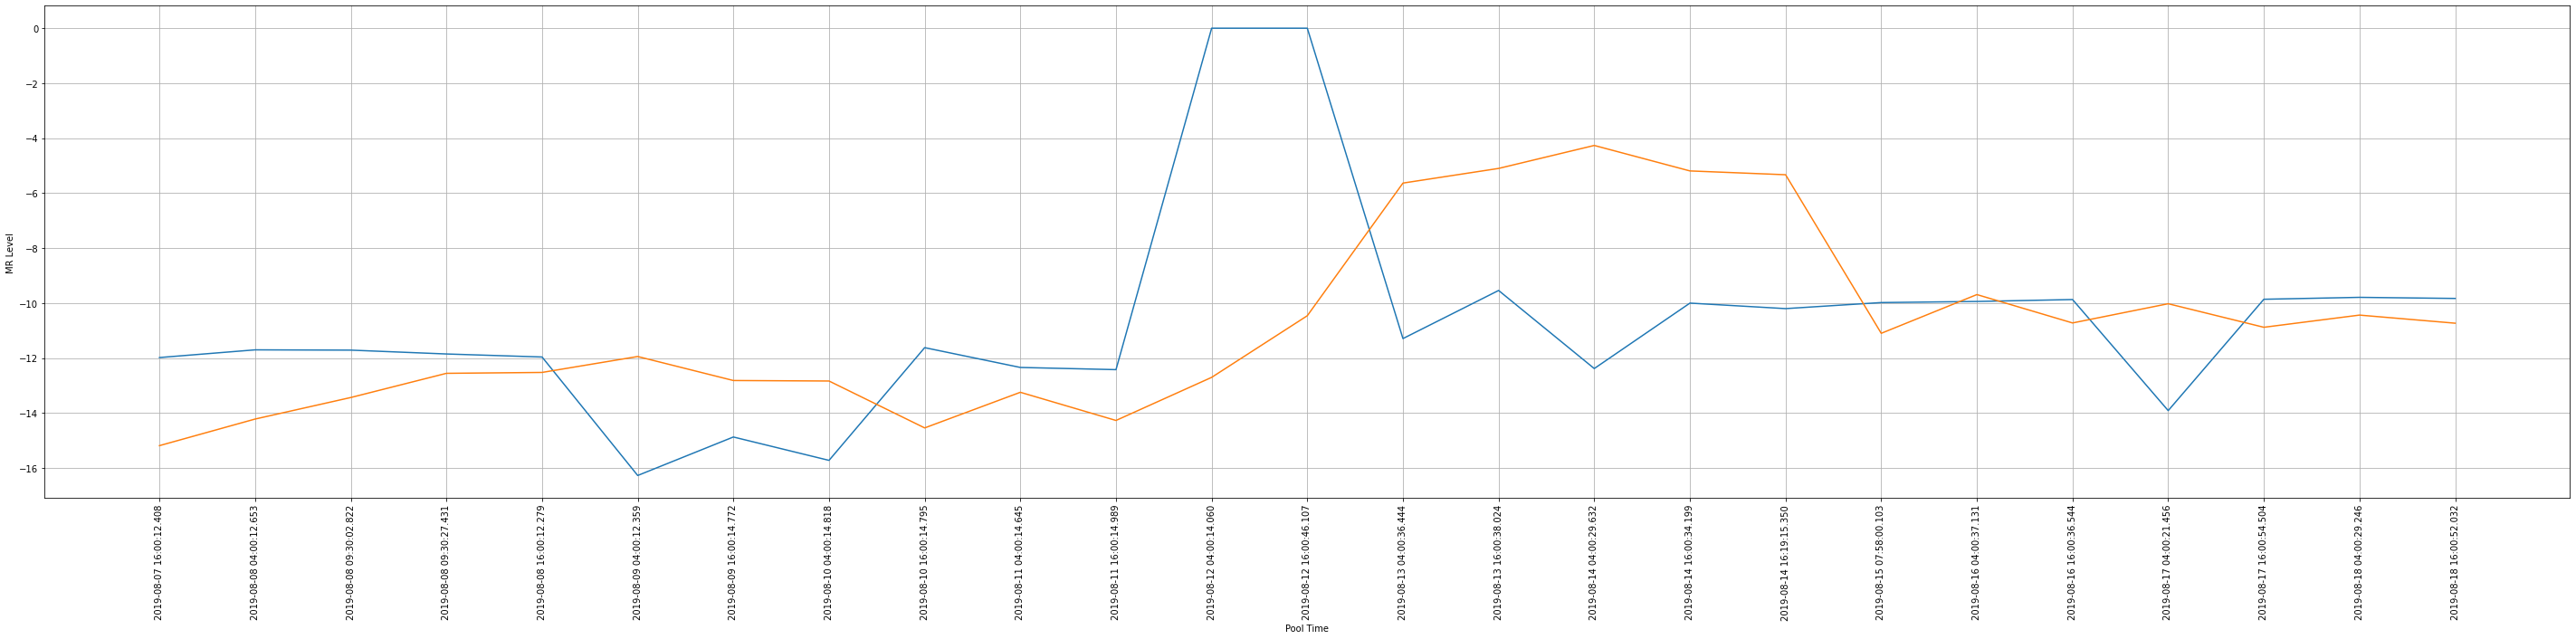

In [125]:
forecast=[]
series_new = red_zone_list[2]
x_train = series_new[:split_time]
x_valid = series_new[split_time:]
time_train = poll_times[:split_time]
time_valid = poll_times[split_time:]
series_new = np.array(series_new)
for time in range(len(series_new) - window_size):
  forecast.append(model.predict(series_new[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

configure_chart()
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [126]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.3349402